In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from multiprocessing import Pool

In [2]:
def simulate(G, H, trialtime, threshG, threshH, N):    
    results = np.zeros([trialtime])
    #redun_connections= np.ones([trialtime])
    #timetaken = np.zeros([trialtime])
    nodeset = set(range(N))
    infected = set()
    for t in range(trialtime):

        results[t] = len(infected)
        if t> trialtime/2 :
            if results[t] == results[t-1]:
                results[range(t+1, trialtime)] = results[t]
                break
        
        temphold = set()
        
        for node in nodeset-infected:
            neighG = {n for n in G.neighbors(node)}
            neighH = {n for n in H.neighbors(node)}

            if len(infected.intersection(neighG)) > threshG[node]*len(neighG) and len(infected.intersection(neighH)) > threshH[node]*len(neighH):
                temphold.update({node})
        
        infected.update(temphold)
    return results


In [3]:
def one_layer_finalfrac(G, trialtime, thresh, N):
    nodeset = set(G.nodes())
    infected = set()
    for t in range(trialtime):
        
        
        temphold = set()
        
        for node in nodeset-infected:
            neigh = {n for n in G.neighbors(node)}
            if len(infected.intersection(neigh)) > thresh[node]*len(neigh):
                temphold.update({node})
                
        if len(temphold) == 0:
            break
        else: 
            infected.update(temphold)
        
        infected.update(temphold)
    
    return len(infected)

In [4]:
def finalfraction(G, H, trialtime, threshG, threshH, N):    
    nodeset = set(G.nodes())
    infected = set()
    for t in range(trialtime):
        
        temphold = set()
        
        for node in nodeset-infected:
            neighG = {n for n in G.neighbors(node)}
            neighH = {n for n in H.neighbors(node)}

            if len(infected.intersection(neighG)) > threshG[node]*len(neighG) and len(infected.intersection(neighH)) > threshH[node]*len(neighH):
                temphold.update({node})
        
        if len(temphold) == 0:
            break
        else: 
            infected.update(temphold)
        
    
    return len(infected)
    

In [5]:
def comm_network(G, n_swap, N):
    H = G.copy()
    H = nx.double_edge_swap(H, n_swap, max_tries=n_swap*N);
    return H

In [6]:
#This is maximum edge swap, uncorrelated degrees
def go_edge(z):
    finesse=21
    N = 1000
    p = z/N
    trialnumber = 10
    trialtime = 25
    sigma = 0.2

    G = nx.fast_gnp_random_graph(N, p, seed=None, directed=False)
    H = comm_network(G, G.number_of_edges()+N, N)
    results = np.zeros([finesse])
    
    for T in range(trialnumber):     
        for n in range(finesse):
            threshG = np.random.normal(n*0.4/finesse, sigma, N)
            threshH = np.random.normal(n*0.4/finesse, sigma, N)
            results[n] = results[n] + finalfraction(G, H, trialtime, threshG, threshH, N)
    return results/N/trialnumber


In [14]:
def go_single(z):
    finesse=26
    N = 10000
    C = 500 # number of communities
    n = 20#number of vertices per community
    p_out = 0.5/(n*(C-1))
    p_in = (z-0.5)/(n-1)
    
    trialnumber = 5
    trialtime = 50
    sigma = 0.2
    results = np.zeros([finesse])

    G = nx.planted_partition_graph(C, n, p_in, p_out)
     
    for T in range(trialnumber):
        for n in range(finesse):
            thresh = np.random.normal(n*0.5/finesse, sigma, N)
            results[n] = results[n] + one_layer_finalfrac(G, trialtime, thresh, N)
    return results/N/trialnumber


In [8]:
#This is maximum edge swap, uncorrelated degrees
def go_node_pp(z):
    finesse=21
    N = 10000
    C = 500 # number of communities
    n = 20#number of vertices per community
    p_out = 0.5/(n*(C-1))
    p_in = (z-0.5)/(n-1)
    
    trialnumber = 5
    trialtime = 50
    sigma = 0.2
    results = np.zeros([finesse])
    for T in range(trialnumber):
        #G = nx.fast_gnp_random_graph(N, p, seed=None, directed=False)
        #H = nx.fast_gnp_random_graph(N, p, seed=None, directed=False) 
        G = nx.planted_partition_graph(C, n, p_in, p_out)
        H = nx.planted_partition_graph(C, n, p_in, p_out)
        for n in range(finesse):
            threshG = np.random.normal(n*0.4/finesse, sigma, N)
            threshH = np.random.normal(n*0.4/finesse, sigma, N)
            results[n] = results[n] + finalfraction(G, H, trialtime, threshG, threshH, N)
    return results/N/trialnumber


In [8]:
def go_edge_pp(z):
    finesse=21
    N = 10000
    C = 100 # number of communities
    n = 100#number of vertices per community
    p_out = 0.5/(n*(C-1))
    p_in = (z-0.5)/(n-1)
    
    trialnumber = 5
    trialtime = 50
    sigma = 0.2
    results = np.zeros([finesse])
    

    G = nx.planted_partition_graph(C, n, p_in, p_out)
    H = comm_network(G, G.number_of_edges()+N, N)
    
    
    for T in range(trialnumber):
        for n in range(finesse):
            threshG = np.random.normal(n*0.4/finesse, sigma, N)
            threshH = np.random.normal(n*0.4/finesse, sigma, N)
            results[n] = results[n] + finalfraction(G, H, trialtime, threshG, threshH, N)
    return results/N/trialnumber


In [11]:
infectionsize_edge_pp = np.zeros([20, 21])
for n in range(1,21):
    z = n/2
    pool= Pool(3)
    results_edge_pp = pool.map(go_edge_pp, [z]*3)
    infectionsize_edge_pp[n-1] = np.asarray(sum(results_edge_pp), dtype=float)/3
filename = 'pp_double_edge.npy'
np.save(filename, infectionsize_edge_pp)

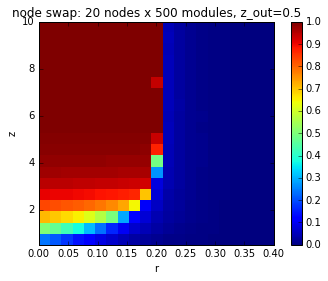

In [12]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(((infectionsize_edge_pp)[::-1]), interpolation='nearest', extent=[0,0.4, 0.5,10] ,vmin=0, vmax=1.0)
fig.colorbar(im)
ax.set_aspect(1/25)
plt.title('node swap: 20 nodes x 500 modules, z_out=0.5')
plt.xlabel('r')
plt.ylabel('z')
plt.show()
fig.savefig('/home/user/Desktop/MP_doc_templates/figures/pp_nodee_20x500.eps',  format='eps', dpi=1000)

In [9]:
trial_results = go_edge_pp(10)


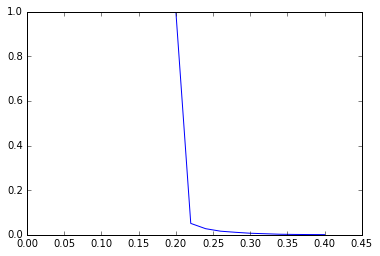

In [10]:
plt.plot(np.arange(21)*0.4/20, trial_results)

In [25]:
0.5/(0.4/20)

25.0

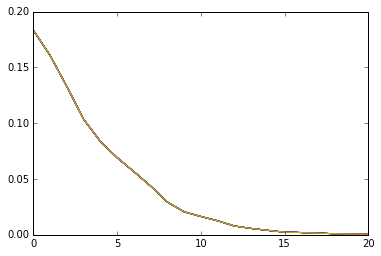

In [17]:
for r in range(20):
    plt.plot(infectionsize_node_pp[r])


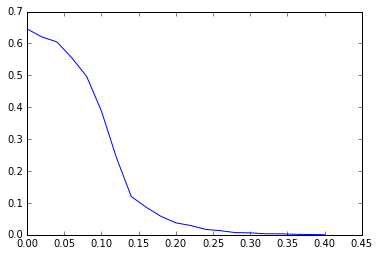

In [21]:
plt.plot(np.arange(21)*0.4/20, infectionsize[4]*10)

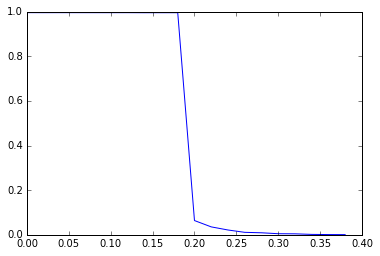

In [20]:
plt.plot(np.arange(20)*0.4/20, infectionsize)


In [22]:
np.linspace(0, 10, 21)

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ])

In [1]:
infectionsize

NameError: name 'infectionsize' is not defined

In [9]:
infectionsize_node_pp.astype('float32').tofile('pp_node_swap_sim_100_com.dat')


In [35]:
filename = 'pp_single_sim_100_com.npy'
np.save(filename, infectionsize_single)

In [7]:
#infectionsize = np.fromfile('node_swap_sim.dat', dtype='float')

In [8]:
infectionsize

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.65329859e-13,   1.65528024e-14,
         7.15990275e-16,   1.37704677e-17,   1.29236965e-19,
         1.31911254e-21,   5.15278337e-24,   9.46777442e-27,
         1.38994386e-28,   1.71393210e-31,   2.61525284e-36,
         1.75833680e-09,   9.20146871e-11,   3.55745857e-12,
         1.74016650e-14,   1.56615464e-16,   3.06329008e-18,
         1.05782004e-20,   1.55910543e-22,   4.96087893e-25,
         2.96621759e-28,   2.99580865e-06,   4.88535645e-07,
         1.25368462e-08,   9.97136397e-11,   2.13367436e-13,
         1.24108135e-15,   4.55191614e-18,   6.36426700e-21,
         6.50803694e-24,   1.30694559e-26,   1.71393210e-31,
         1.17643227e-04,   5.76985839e-05,   2.68656412e-06,
         3.22610215e-10,   8.13209847e-13,   3.31302409e-15,
         3.95979709e-18,

In [13]:
G = nx.planted_partition_graph(100, 100, 9.5/99, 0.5/9900)
H = comm_network(G, G.number_of_edges()+10000, 100000)